# ML HW3 sample code
TODO:
 - Design your AutoEncoder model
 - Pre-training with unlabelled data
    - Augmentation
 - Fine-tuning with labelled data
    - Augmentation
    - Loss function
    - (optional) Design your training scheme

Report:
 - Clustering
    - implement Equilibrium K-means algorithm
    - t-SNE : show the embedding of different classes
 - Anomaly detection
    - reconstruct unseen classes

## Download data

In [2]:
# !gdown 1Bw1ksB6AkTICynIHHkG7NKAdf3sBI1uR
!gdown 1kO12YQxqGFLbY3WiskJyYG7S-hiPae24
!unzip -q 'hw3.zip'

Downloading...
From (original): https://drive.google.com/uc?id=1kO12YQxqGFLbY3WiskJyYG7S-hiPae24
From (redirected): https://drive.google.com/uc?id=1kO12YQxqGFLbY3WiskJyYG7S-hiPae24&confirm=t&uuid=3e4866ab-c38f-4b5f-a62e-ffcd6c3ea3bd
To: /content/hw3.zip
100% 196M/196M [00:01<00:00, 148MB/s]


## Import packages

In [3]:
import os
import random
import csv
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision as tv

import torchvision.transforms as T
from torchvision.transforms import v2
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from argparse import Namespace
from tqdm import tqdm

## Datasets and Dataloaders

In [4]:
def load_unlabelled(img_dir):
    return  [ Image.open(os.path.join(img_dir, str(i)+'.jpg')) for i in range(len(os.listdir(img_dir))) ]


def load_labelled(root_dir):
    data = []
    labels = []
    for label in os.listdir(root_dir):
        for img in os.listdir(os.path.join(root_dir, label)):
            img = Image.open(os.path.join(root_dir, label, img))
            data.append(img)
            labels.append(int(label))
    return [*zip(data, labels)]

class ImageDataset(Dataset):
    def __init__(self, imgs, labels=None, tfm=T.ToTensor()):
        super().__init__()
        self.imgs = imgs
        self.labels = labels
        self.tfm = tfm
    def __getitem__(self, idx):
        if self.labels is None:
            return self.tfm(self.imgs[idx])
            # return nn.AvgPool2d(2,2)(self.tfm(self.imgs[idx]))
        else:
            return self.tfm(self.imgs[idx]), self.labels[idx]
            # return nn.AvgPool2d(2,2)(self.tfm(self.imgs[idx])), self.labels[idx]
    def __len__(self):
        return len(self.imgs)

## AutoEncoder model
<span style="color:orange">(TODO: design your model)</span>.

<img src="https://julien-vitay.net/lecturenotes-neurocomputing/_images/semisupervised-autoencoder.png" width="500"/>

In [5]:
# TODO: Implement your autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Flatten(start_dim=1),   # Flatten to feed into the linear layer
            nn.Linear(512*4*4, 1024) # change to 2048
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(1024, 512*4*4),
            nn.Unflatten(dim=1, unflattened_size=(512, 4, 4)),   # Unflatten
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Use sigmoid to get pixel values between 0 and 1
        )

        # classifier head
        self.predictor = nn.Sequential(
            nn.Linear(1024, 1024),   # Latent space with 1024 features
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        # encode
        z = self.encoder(x)
        # decode
        x_prime = self.decoder(z)
        # classify
        y = self.predictor(z)
        return x_prime, y, z

## Pre-train with unlabelled data
<span style="color:orange">(TODO: hyperparameter tuning/augmentation)</span>.

In [6]:
def add_noise(x, noise_factor=0.1):
    noise = noise_factor * torch.randn_like(x)
    return x + noise

def pretrain(model, train_loader, valid_loader, config, noise_function=add_noise):
    model = model.to(config.device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    best_valid_loss = 1e9
    for epoch in range(config.pretrain_epochs):
        model.train()
        train_loss = 0
        for img in tqdm(train_loader):
            img = img.to(config.device)
            optimizer.zero_grad()
            output, _, _ = model(noise_function(img, config.noise_factor))
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        if valid_loader is not None:
            model.eval()
            valid_loss = 0
            with torch.no_grad():
                for img in valid_loader:
                    img = img.to(config.device)
                    output, _, _ = model(img)
                    loss = criterion(output, img)
                    valid_loss += loss.item()
                valid_loss /= len(valid_loader)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), config.pretrain_model_path)

            print(f'Epoch {epoch+1}/{config.pretrain_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

In [7]:
# TODO: Determine your hyperparameters and augmentation for pretraining
pretrain_train_tfm = v2.Compose([
    v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    v2.RandomHorizontalFlip(p=0.5),  # Horizontal flip with 50% probability
    v2.RandomVerticalFlip(p=0.3),
    v2.RandomRotation(90),  # Random rotation between -10° to 10°
    # v2.AutoAugment(random.choice([
    #     v2.AutoAugmentPolicy.CIFAR10,
    #     v2.AutoAugmentPolicy.IMAGENET
    # ])),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    v2.ToDtype(torch.float32, scale=True),  # Convert to float
])

pretrain_valid_tfm = v2.Compose([
    # v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    # v2.ToDtype(torch.float32, scale=True),  # Convert to float
    T.ToTensor()
])

pretrain_config = Namespace(
    batch_size = 256,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    lr = 1e-3, # 1e-3
    weight_decay = 0, # 0
    noise_factor = 0.01, # 0.01
    pretrain_epochs = 15, #10
    pretrain_model_path = 'pretrain_model.ckpt'
)

In [8]:
pretrain_train_data = load_unlabelled('data/dev/unlabelled')
pretrain_train_data, pretrain_valid_data = torch.utils.data.random_split(pretrain_train_data, [0.8, 0.2])
pretrain_train_dataset, pretrain_valid_dataset = ImageDataset(pretrain_train_data, tfm=pretrain_train_tfm), ImageDataset(pretrain_valid_data, tfm=pretrain_valid_tfm)

pretrain_train_loader = DataLoader(pretrain_train_dataset, batch_size=pretrain_config.batch_size, shuffle=True)
pretrain_valid_loader = DataLoader(pretrain_valid_dataset, batch_size=pretrain_config.batch_size, shuffle=False)

In [ ]:
model = Autoencoder()
pretrain(model, pretrain_train_loader, pretrain_valid_loader, pretrain_config)

100%|██████████| 313/313 [03:26<00:00,  1.52it/s]


Epoch 1/15, Train Loss: 0.0319, Valid Loss: 0.0224


100%|██████████| 313/313 [03:13<00:00,  1.61it/s]


Epoch 2/15, Train Loss: 0.0171, Valid Loss: 0.0154


100%|██████████| 313/313 [03:15<00:00,  1.60it/s]


Epoch 3/15, Train Loss: 0.0126, Valid Loss: 0.0122


100%|██████████| 313/313 [03:15<00:00,  1.60it/s]


Epoch 4/15, Train Loss: 0.0108, Valid Loss: 0.0111


100%|██████████| 313/313 [03:13<00:00,  1.62it/s]


Epoch 5/15, Train Loss: 0.0096, Valid Loss: 0.0098


100%|██████████| 313/313 [03:13<00:00,  1.62it/s]


Epoch 6/15, Train Loss: 0.0088, Valid Loss: 0.0086


100%|██████████| 313/313 [03:13<00:00,  1.62it/s]


Epoch 7/15, Train Loss: 0.0082, Valid Loss: 0.0081


100%|██████████| 313/313 [03:14<00:00,  1.61it/s]


Epoch 8/15, Train Loss: 0.0077, Valid Loss: 0.0078


100%|██████████| 313/313 [03:12<00:00,  1.62it/s]


Epoch 9/15, Train Loss: 0.0073, Valid Loss: 0.0072


100%|██████████| 313/313 [03:13<00:00,  1.61it/s]


Epoch 10/15, Train Loss: 0.0070, Valid Loss: 0.0070


100%|██████████| 313/313 [03:13<00:00,  1.61it/s]


Epoch 11/15, Train Loss: 0.0068, Valid Loss: 0.0070


100%|██████████| 313/313 [03:12<00:00,  1.63it/s]


Epoch 12/15, Train Loss: 0.0065, Valid Loss: 0.0064


100%|██████████| 313/313 [03:11<00:00,  1.63it/s]


Epoch 13/15, Train Loss: 0.0063, Valid Loss: 0.0061


100%|██████████| 313/313 [03:09<00:00,  1.65it/s]


Epoch 14/15, Train Loss: 0.0061, Valid Loss: 0.0061


100%|██████████| 313/313 [03:10<00:00,  1.65it/s]


Epoch 15/15, Train Loss: 0.0059, Valid Loss: 0.0060


## Fine-tuning with labelled data
<span style="color:orange">(TODO: loss function/training scheme/augmentation)</span>.

In [9]:
def loss_fn(x_prime, y, z, x, y_hat):
    # TODO: Define your loss function for fine-tuning
    # You might want to consider the reconstruction loss and/or the classification loss
    reconstruction_loss = nn.MSELoss()(x_prime, x)
    classification_loss = nn.CrossEntropyLoss()(y, y_hat)
    total_loss = reconstruction_loss + classification_loss
    return total_loss


def finetune(model, train_loader, valid_loader, config, noise_function=add_noise):
    model = model.to(config.device)
    criterion = loss_fn
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    best_valid_loss = 1e9
    for epoch in range(config.finetune_epochs):
        model.train()
        train_loss, train_acc = 0, 0
        for img, label in tqdm(train_loader):
            img, label = img.to(config.device), label.to(config.device)
            optimizer.zero_grad()
            output = model(noise_function(img, config.noise_factor))
            loss = criterion(*output, img, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (output[1].argmax(dim=1) == label).float().mean().item()
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        print(f'Epoch {epoch+1}/{config.finetune_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

        model.eval()
        valid_loss, valid_acc = 0, 0
        with torch.no_grad():
            for img, label in valid_loader:
                img, label = img.to(config.device), label.to(config.device)
                output = model(img)
                loss = criterion(*output, img, label)
                valid_loss += loss.item()
                valid_acc += (output[1].argmax(dim=1) == label).float().mean().item()
            valid_loss /= len(valid_loader)
            valid_acc /= len(valid_loader)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), config.finetune_model_path)

        print(f'Epoch {epoch+1}/{config.finetune_epochs}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')

In [10]:
# TODO: Determine your hyperparameters and augmentation for pretraining
finetune_train_tfm = v2.Compose([
    v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    # v2.ToDtype(torch.uint8, scale=True),  # Ensure input is uint8
    v2.RandomHorizontalFlip(p=0.5),  # Horizontal flip with 50% probability
    v2.RandomVerticalFlip(p=0.2),
    v2.RandomRotation(30),  # Random rotation between -30° to 30°
    # v2.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # v2.AutoAugment(random.choice([
    #     v2.AutoAugmentPolicy.CIFAR10,
    #     v2.AutoAugmentPolicy.IMAGENET
    # ])),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    v2.RandomErasing(0.4, (0.02, 0.10), ratio = (0.3,3.3)),
    v2.ToDtype(torch.float32, scale=True),  # Convert to float
])
finetune_valid_tfm = v2.Compose([
    # v2.RandomHorizontalFlip(p=0.5),  # Horizontal flip with 50% probability
    T.ToTensor()
])

finetune_config = Namespace(
    batch_size = 16,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    lr = 1e-3,
    weight_decay = 1e-7,
    noise_factor = 0.01,
    finetune_epochs = 50, #30
    finetune_model_path = 'finetune_model.ckpt'
)

In [20]:
finetune_train_data = load_labelled('data/dev/labelled')
finetune_train_data, finetune_valid_data = torch.utils.data.random_split(finetune_train_data, [0.8, 0.2])
finetune_train_dataset, finetune_valid_dataset = ImageDataset(*map(list, zip(*finetune_train_data)), finetune_train_tfm), ImageDataset(*map(list, zip(*finetune_valid_data)), finetune_valid_tfm)

finetune_train_loader = DataLoader(finetune_train_dataset, batch_size=finetune_config.batch_size, shuffle=True)
finetune_valid_loader = DataLoader(finetune_valid_dataset, batch_size=finetune_config.batch_size, shuffle=False)

In [21]:
model = Autoencoder()
model.load_state_dict(torch.load(pretrain_config.pretrain_model_path))
finetune(model, finetune_train_loader, finetune_valid_loader, finetune_config)

<ipython-input-21-07bd0fa2815e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrain_config.pretrain_model_path))
100%|██████████| 188/

Epoch 1/50, Train Loss: 2.1876, Train Acc: 0.2643
Epoch 1/50, Valid Loss: 1.9551, Valid Acc: 0.3216


100%|██████████| 188/188 [00:09<00:00, 19.15it/s]


Epoch 2/50, Train Loss: 1.9335, Train Acc: 0.3118
Epoch 2/50, Valid Loss: 1.7491, Valid Acc: 0.3484


100%|██████████| 188/188 [00:09<00:00, 19.25it/s]


Epoch 3/50, Train Loss: 1.8494, Train Acc: 0.3281
Epoch 3/50, Valid Loss: 1.6791, Valid Acc: 0.3693


100%|██████████| 188/188 [00:09<00:00, 19.70it/s]


Epoch 4/50, Train Loss: 1.8243, Train Acc: 0.3268
Epoch 4/50, Valid Loss: 1.7004, Valid Acc: 0.3425


100%|██████████| 188/188 [00:09<00:00, 20.54it/s]


Epoch 5/50, Train Loss: 1.8000, Train Acc: 0.3431
Epoch 5/50, Valid Loss: 1.8083, Valid Acc: 0.2979


100%|██████████| 188/188 [00:09<00:00, 19.28it/s]


Epoch 6/50, Train Loss: 1.7781, Train Acc: 0.3434
Epoch 6/50, Valid Loss: 1.6331, Valid Acc: 0.3535


100%|██████████| 188/188 [00:10<00:00, 17.97it/s]


Epoch 7/50, Train Loss: 1.7203, Train Acc: 0.3614
Epoch 7/50, Valid Loss: 1.6584, Valid Acc: 0.3682


100%|██████████| 188/188 [00:09<00:00, 20.53it/s]


Epoch 8/50, Train Loss: 1.7298, Train Acc: 0.3740
Epoch 8/50, Valid Loss: 1.6842, Valid Acc: 0.3790


100%|██████████| 188/188 [00:09<00:00, 19.63it/s]


Epoch 9/50, Train Loss: 1.7208, Train Acc: 0.3713
Epoch 9/50, Valid Loss: 1.5912, Valid Acc: 0.3722


100%|██████████| 188/188 [00:09<00:00, 19.32it/s]


Epoch 10/50, Train Loss: 1.6936, Train Acc: 0.3723
Epoch 10/50, Valid Loss: 1.5591, Valid Acc: 0.3923


100%|██████████| 188/188 [00:09<00:00, 20.02it/s]


Epoch 11/50, Train Loss: 1.6759, Train Acc: 0.3680
Epoch 11/50, Valid Loss: 1.8020, Valid Acc: 0.3532


100%|██████████| 188/188 [00:09<00:00, 20.68it/s]


Epoch 12/50, Train Loss: 1.6530, Train Acc: 0.3903
Epoch 12/50, Valid Loss: 1.8332, Valid Acc: 0.3746


100%|██████████| 188/188 [00:10<00:00, 18.10it/s]


Epoch 13/50, Train Loss: 1.6507, Train Acc: 0.3853
Epoch 13/50, Valid Loss: 1.5724, Valid Acc: 0.4069


100%|██████████| 188/188 [00:09<00:00, 19.37it/s]


Epoch 14/50, Train Loss: 1.6593, Train Acc: 0.3910
Epoch 14/50, Valid Loss: 1.6358, Valid Acc: 0.4109


100%|██████████| 188/188 [00:08<00:00, 21.10it/s]


Epoch 15/50, Train Loss: 1.6682, Train Acc: 0.3860
Epoch 15/50, Valid Loss: 1.6139, Valid Acc: 0.4134


100%|██████████| 188/188 [00:09<00:00, 19.36it/s]


Epoch 16/50, Train Loss: 1.6882, Train Acc: 0.3923
Epoch 16/50, Valid Loss: 1.6111, Valid Acc: 0.4134


100%|██████████| 188/188 [00:09<00:00, 19.62it/s]


Epoch 17/50, Train Loss: 1.6113, Train Acc: 0.3996
Epoch 17/50, Valid Loss: 1.5137, Valid Acc: 0.4214


100%|██████████| 188/188 [00:09<00:00, 20.35it/s]


Epoch 18/50, Train Loss: 1.5949, Train Acc: 0.4146
Epoch 18/50, Valid Loss: 1.5104, Valid Acc: 0.4535


100%|██████████| 188/188 [00:09<00:00, 20.52it/s]


Epoch 19/50, Train Loss: 1.5791, Train Acc: 0.4205
Epoch 19/50, Valid Loss: 1.4837, Valid Acc: 0.4612


100%|██████████| 188/188 [00:09<00:00, 19.39it/s]


Epoch 20/50, Train Loss: 1.5792, Train Acc: 0.4119
Epoch 20/50, Valid Loss: 1.5144, Valid Acc: 0.4464


100%|██████████| 188/188 [00:10<00:00, 18.41it/s]


Epoch 21/50, Train Loss: 1.5524, Train Acc: 0.4225
Epoch 21/50, Valid Loss: 1.4682, Valid Acc: 0.4573


100%|██████████| 188/188 [00:09<00:00, 19.79it/s]


Epoch 22/50, Train Loss: 1.5522, Train Acc: 0.4312
Epoch 22/50, Valid Loss: 1.5382, Valid Acc: 0.4001


100%|██████████| 188/188 [00:09<00:00, 20.19it/s]


Epoch 23/50, Train Loss: 1.5277, Train Acc: 0.4455
Epoch 23/50, Valid Loss: 1.4458, Valid Acc: 0.4550


100%|██████████| 188/188 [00:09<00:00, 19.24it/s]


Epoch 24/50, Train Loss: 1.5131, Train Acc: 0.4345
Epoch 24/50, Valid Loss: 1.4280, Valid Acc: 0.4918


100%|██████████| 188/188 [00:09<00:00, 19.29it/s]


Epoch 25/50, Train Loss: 1.4780, Train Acc: 0.4727
Epoch 25/50, Valid Loss: 1.5045, Valid Acc: 0.4776


100%|██████████| 188/188 [00:08<00:00, 21.39it/s]


Epoch 26/50, Train Loss: 1.5128, Train Acc: 0.4561
Epoch 26/50, Valid Loss: 1.3390, Valid Acc: 0.5228


100%|██████████| 188/188 [00:09<00:00, 19.45it/s]


Epoch 27/50, Train Loss: 1.4929, Train Acc: 0.4458
Epoch 27/50, Valid Loss: 1.5161, Valid Acc: 0.4666


100%|██████████| 188/188 [00:09<00:00, 19.13it/s]


Epoch 28/50, Train Loss: 1.4799, Train Acc: 0.4688
Epoch 28/50, Valid Loss: 1.4586, Valid Acc: 0.5146


100%|██████████| 188/188 [00:09<00:00, 20.62it/s]


Epoch 29/50, Train Loss: 1.4690, Train Acc: 0.4638
Epoch 29/50, Valid Loss: 1.3728, Valid Acc: 0.4973


100%|██████████| 188/188 [00:09<00:00, 19.81it/s]


Epoch 30/50, Train Loss: 1.4363, Train Acc: 0.4874
Epoch 30/50, Valid Loss: 1.4020, Valid Acc: 0.4894


100%|██████████| 188/188 [00:09<00:00, 19.25it/s]


Epoch 31/50, Train Loss: 1.4402, Train Acc: 0.4847
Epoch 31/50, Valid Loss: 1.8576, Valid Acc: 0.4069


100%|██████████| 188/188 [00:09<00:00, 20.42it/s]


Epoch 32/50, Train Loss: 1.4273, Train Acc: 0.4897
Epoch 32/50, Valid Loss: 1.5107, Valid Acc: 0.5215


100%|██████████| 188/188 [00:09<00:00, 20.45it/s]


Epoch 33/50, Train Loss: 1.3763, Train Acc: 0.5096
Epoch 33/50, Valid Loss: 1.4143, Valid Acc: 0.5414


100%|██████████| 188/188 [00:09<00:00, 19.29it/s]


Epoch 34/50, Train Loss: 1.3766, Train Acc: 0.5103
Epoch 34/50, Valid Loss: 1.6227, Valid Acc: 0.4734


100%|██████████| 188/188 [00:09<00:00, 19.37it/s]


Epoch 35/50, Train Loss: 1.3520, Train Acc: 0.5283
Epoch 35/50, Valid Loss: 1.3835, Valid Acc: 0.5243


100%|██████████| 188/188 [00:08<00:00, 21.11it/s]


Epoch 36/50, Train Loss: 1.3604, Train Acc: 0.5246
Epoch 36/50, Valid Loss: 1.3944, Valid Acc: 0.5374


100%|██████████| 188/188 [00:09<00:00, 19.16it/s]


Epoch 37/50, Train Loss: 1.3276, Train Acc: 0.5246
Epoch 37/50, Valid Loss: 1.3516, Valid Acc: 0.5268


100%|██████████| 188/188 [00:09<00:00, 19.10it/s]


Epoch 38/50, Train Loss: 1.3273, Train Acc: 0.5452
Epoch 38/50, Valid Loss: 1.3614, Valid Acc: 0.5175


100%|██████████| 188/188 [00:09<00:00, 20.43it/s]


Epoch 39/50, Train Loss: 1.3029, Train Acc: 0.5462
Epoch 39/50, Valid Loss: 1.2459, Valid Acc: 0.5826


100%|██████████| 188/188 [00:09<00:00, 19.88it/s]


Epoch 40/50, Train Loss: 1.3068, Train Acc: 0.5309
Epoch 40/50, Valid Loss: 1.2406, Valid Acc: 0.5456


100%|██████████| 188/188 [00:09<00:00, 19.05it/s]


Epoch 41/50, Train Loss: 1.2786, Train Acc: 0.5552
Epoch 41/50, Valid Loss: 1.5244, Valid Acc: 0.5028


100%|██████████| 188/188 [00:09<00:00, 18.94it/s]


Epoch 42/50, Train Loss: 1.3040, Train Acc: 0.5442
Epoch 42/50, Valid Loss: 1.4871, Valid Acc: 0.5256


100%|██████████| 188/188 [00:08<00:00, 21.12it/s]


Epoch 43/50, Train Loss: 1.2773, Train Acc: 0.5475
Epoch 43/50, Valid Loss: 1.3070, Valid Acc: 0.5669


100%|██████████| 188/188 [00:09<00:00, 19.00it/s]


Epoch 44/50, Train Loss: 1.2354, Train Acc: 0.5642
Epoch 44/50, Valid Loss: 1.3767, Valid Acc: 0.5215


100%|██████████| 188/188 [00:09<00:00, 18.83it/s]


Epoch 45/50, Train Loss: 1.2375, Train Acc: 0.5748
Epoch 45/50, Valid Loss: 1.2788, Valid Acc: 0.5785


100%|██████████| 188/188 [00:09<00:00, 20.49it/s]


Epoch 46/50, Train Loss: 1.2312, Train Acc: 0.5795
Epoch 46/50, Valid Loss: 1.6938, Valid Acc: 0.5133


100%|██████████| 188/188 [00:10<00:00, 18.58it/s]


Epoch 47/50, Train Loss: 1.2034, Train Acc: 0.5921
Epoch 47/50, Valid Loss: 1.4149, Valid Acc: 0.5239


100%|██████████| 188/188 [00:10<00:00, 18.79it/s]


Epoch 48/50, Train Loss: 1.1784, Train Acc: 0.6047
Epoch 48/50, Valid Loss: 1.3054, Valid Acc: 0.5788


100%|██████████| 188/188 [00:09<00:00, 19.36it/s]


Epoch 49/50, Train Loss: 1.1783, Train Acc: 0.5957
Epoch 49/50, Valid Loss: 1.2919, Valid Acc: 0.5786


100%|██████████| 188/188 [00:09<00:00, 20.65it/s]


Epoch 50/50, Train Loss: 1.1703, Train Acc: 0.5951
Epoch 50/50, Valid Loss: 1.2287, Valid Acc: 0.5946


100%|██████████| 188/188 [00:06<00:00, 29.14it/s]
Epoch 28/30, Train Loss: 1.1141, Train Acc: 0.5947
Epoch 28/30, Valid Loss: 1.5138, Valid Acc: 0.5122
100%|██████████| 188/188 [00:07<00:00, 26.50it/s]
Epoch 29/30, Train Loss: 1.1032, Train Acc: 0.6017
Epoch 29/30, Valid Loss: 1.4750, Valid Acc: 0.4954
100%|██████████| 188/188 [00:06<00:00, 29.17it/s]
Epoch 30/30, Train Loss: 1.1089, Train Acc: 0.5957
Epoch 30/30, Valid Loss: 1.4594, Valid Acc: 0.5175

## Testing

In [34]:
test_dataset = ImageDataset(load_unlabelled('data/test'))
test_loader = DataLoader(test_dataset, batch_size=finetune_config.batch_size, shuffle=False)

model = Autoencoder()
model.load_state_dict(torch.load('finetune_model.ckpt'))
model = model.to(finetune_config.device).eval()

# Generate predictions
predictions = []
with torch.no_grad():
    for img in test_loader:
        img = img.to(finetune_config.device)
        _, y, _ = model(img)
        predictions.append(y.argmax(dim=1).cpu().numpy())
predictions = np.concatenate(predictions)

# Save predictions
with open('predict.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'label'])
    for id, r in enumerate(predictions):
        writer.writerow([id, r])

<ipython-input-34-964880e50211>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('finetune_model.ckpt'))


## Report

### Clustering
<span style="color:orange">(TODO: implement the Equilibrium k-means algorithm)</span>.
ref: https://arxiv.org/pdf/2402.14490

Distance between a data point $x_n$ and centroid $c_k$
$$d_{ik} = \frac{1}{2} \| x_i - c_k \|^2$$

Equation 38: Weight calculation
$$w_{kn}^{(\tau)} = \frac{e^{-\alpha d_{kn}^{(\tau)}}}{\sum_{i=1}^K e^{-\alpha d_{in}^{(\tau)}}}
\left[ 1 - \alpha \left( d_{kn}^{(\tau)} -
\frac{\sum_{i=1}^K d_{in}^{(\tau)} e^{-\alpha d_{in}^{(\tau)}}}{\sum_{i=1}^K e^{-\alpha d_{in}^{(\tau)}}}
\right) \right]$$

Equation 39: Centroid update
$$c_k^{(\tau+1)} = \frac{\sum_{n=1}^N w_{kn}^{(\tau)} x_n}{\sum_{n=1}^N w_{kn}^{(\tau)}}$$

<img src="https://dt5vp8kor0orz.cloudfront.net/5fedcaeba7180898deb71d026db359b0a56af6b3/9-Figure4-1.png" width="1000"/>

In [23]:
import numpy as np

def equilibrium_k_means(X, k, alpha, n_iter):
    centroids = initialize_centroids(X, k) # Initialize centroids
    for _ in range(n_iter):
        weights = Eq38_compute_weights(X, centroids, alpha)  # Compute weights
        centroids = Eq39_update_centroids(X, weights)    # Update centroids
    return centroids

def initialize_centroids(X, k):
    # Initialize centroids as random samples
    return X[np.random.choice(X.shape[0], k, replace=False)]

def Eq38_compute_weights(X, centroids, alpha):
    def distance(x1, x2):
        return (0.5 * np.linalg.norm(x1 - x2)**2)

    weights = np.zeros((X.shape[0], centroids.shape[0]))

    for n in range(X.shape[0]): # n_observation
        for k in range(centroids.shape[0]): # K Dimension
            d_kn = distance(X[n], centroids[k])
            numerator_1 = np.exp(-(alpha * d_kn))
            denominator = np.sum([np.exp(-(alpha * distance(X[n], centroids[i]))) for i in range(centroids.shape[0])])
            denominator += 1e-8 # avoid denominator=0
            numerator_2 = np.sum([distance(X[n], centroids[i]) * np.exp(-(alpha * distance(X[n], centroids[i]))) for i in range(centroids.shape[0])])
            weight = (numerator_1 / denominator) * (1 - (alpha * (d_kn - (numerator_2 / denominator))))
            weights[n, k] = weight
    return weights

def Eq39_update_centroids(X, weights):
    K = weights.shape[1]
    centroids = np.zeros((K, X.shape[1]))
    for k in range(K): # K
      # The weights for the current cluster k
      cluster_weights = weights[:, k]
      # Apply weights to the corresponding data points before summing
      numerator = np.sum(cluster_weights[:, np.newaxis] * X, axis=0)
      denominator = np.sum(weights[:, k]) + 1e-8 # avoid denominator=0
      centroids[k] = numerator / denominator
    return centroids

def select_clusters(weights):
    return np.argmax(weights, axis=1)

def plot_clusters(X, centroids, clustering, title='Equilibrium K-Means Clustering'):
    plt.scatter(X[:,0], X[:,1], c=clustering, cmap='viridis')
    plt.scatter(centroids[:,0], centroids[:,1], c='red', marker='x')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.show()
# Example usage
# np.random.seed(42)
# X1 = np.random.rand(100, 2) + np.array([[0.2,0.2]])
# X2 = np.random.rand(20, 2) + np.array([[0.2,1.6]])
# X3 = np.random.rand(40, 2) + np.array([[2.0,0.5]])
# X = np.concatenate([X1, X2, X3])

# k = 3  # Number of clusters
# n_iter = 50  # Number of iterations
# for alpha in [1, 10, 100, 1000]:
#   centroids = equilibrium_k_means(X, k, alpha, n_iter)
#   print("Final centroids:\n", centroids)
#   print("Real centroids:\n", np.array([np.mean(X1, axis=0), np.mean(X2, axis=0), np.mean(X3, axis=0)]))

#   # Visualize the clustering - show the data points and the centroids
#   clustering = select_clusters(Eq38_compute_weights(X, centroids, alpha))
#   plot_clusters(X, centroids, clustering, title=f'Equilibrium K-Means Clustering (alpha={alpha})')

### t-SNE
<span style="color:orange">(TODO: implement t-SNE)</span>.

In [24]:
import sklearn
from sklearn import manifold

def prune_dimension(X, perp=30):
    X_embedded = manifold.TSNE(n_components=2, method='exact',
     learning_rate='auto', init='pca', perplexity=perp, random_state=42).fit_transform(X)
    return X[:, :2]

### Demo with validation set
This section demonstrate the functionality of t-SNE and clustering with the finetuning validation set
 - Use clustered label
 - Use ground truth label

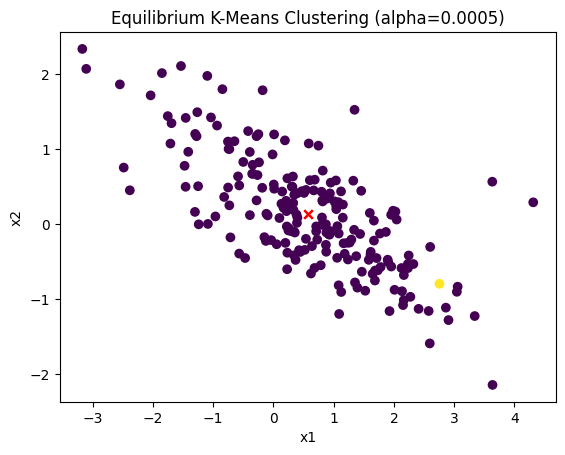

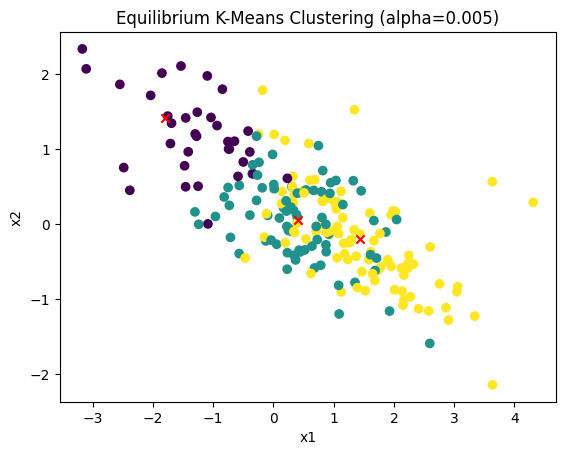

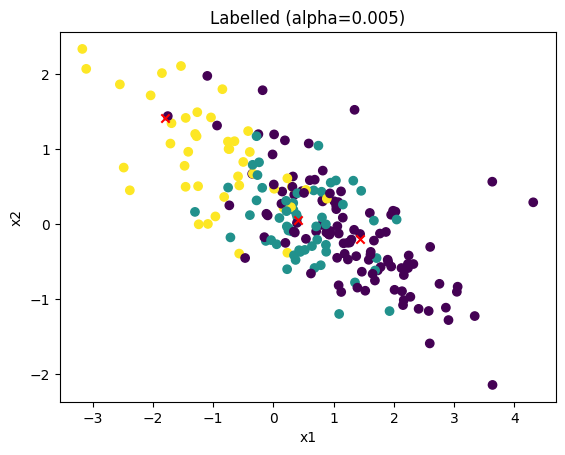

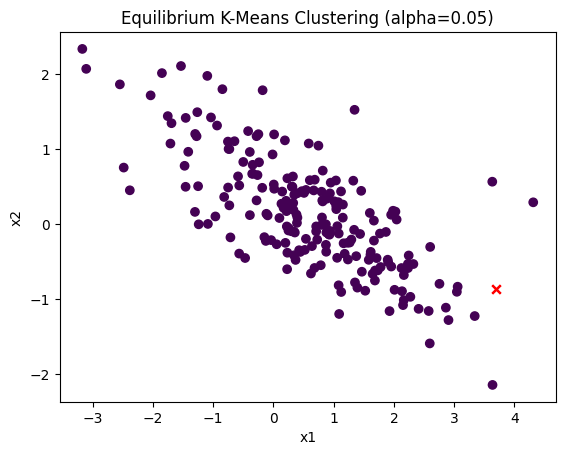

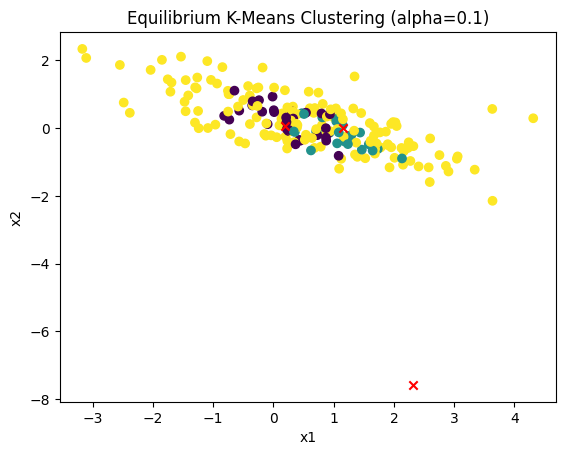

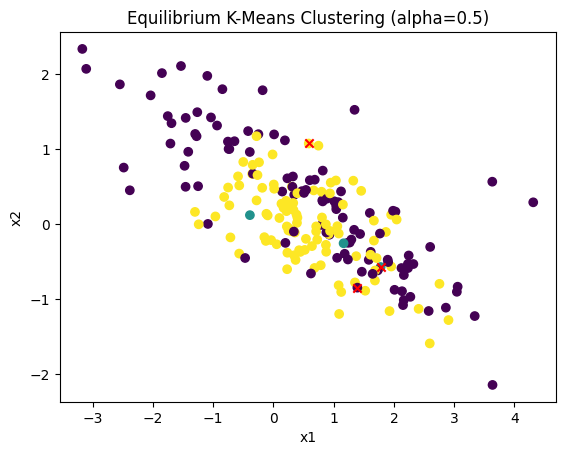

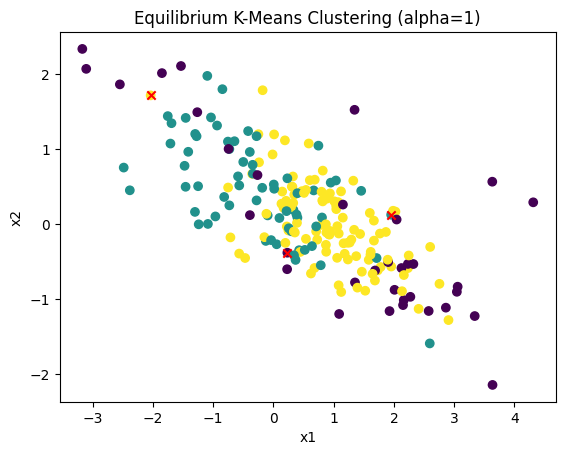

In [35]:
# Generate X, label
X, label = [], []
with torch.no_grad():
    for img, lab in finetune_valid_dataset:
        _, probs, latent_embedding = model(img.unsqueeze(0).to(finetune_config.device))
        X.append(latent_embedding.cpu().numpy())
        label.append(lab)
X, label = np.concatenate(X), np.array(label)

# consider three classes
cls1, cls2, cls3 = 2, 5, 8
cls_idx = np.where((label==cls1) | (label==cls2) | (label==cls3))
X = X[cls_idx]
label = label[cls_idx]

# Perform equilibrium k-means clustering
k = 3
# alpha = 5
n_iter = 100
# for alpha in [0.07, 0.7, 7]:
for alpha in [0.0005, 0.005, 0.05, 0.1, 0.5, 1]:
  centroids = equilibrium_k_means(X, k, alpha, n_iter)
  clustering = select_clusters(Eq38_compute_weights(X, centroids, alpha))

  # t-SNE
  Y = prune_dimension(np.concatenate([X, centroids]), perp=30)
  Y, centroids = Y[:-3], Y[-3:]

  # plot
  plot_clusters(Y, centroids, clustering, f'Equilibrium K-Means Clustering (alpha={alpha})')
  if alpha == 0.005:
    plot_clusters(Y, centroids, label, f'Labelled (alpha={alpha})')

### Anomaly detection
This section demonstrate the usage of autoencoders for anomaly detection.

We use the autoencoder to reconstruct an image of an unseen class.

In [31]:
# train on class 1 (cars)
class1_dataset = ImageDataset(load_unlabelled('./data/dev/labelled/2/'))
class1_loader = DataLoader(class1_dataset, batch_size=8, shuffle=True)
model = Autoencoder()
pretrain(model, class1_loader, None, Namespace(
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    lr = pretrain_config.lr,
    weight_decay = 0,
    noise_factor = 0,
    pretrain_epochs = 50
))

100%|██████████| 63/63 [00:01<00:00, 58.02it/s]


Anomaly loss: 0.05591103434562683
Normal loss : 0.010838131627274884


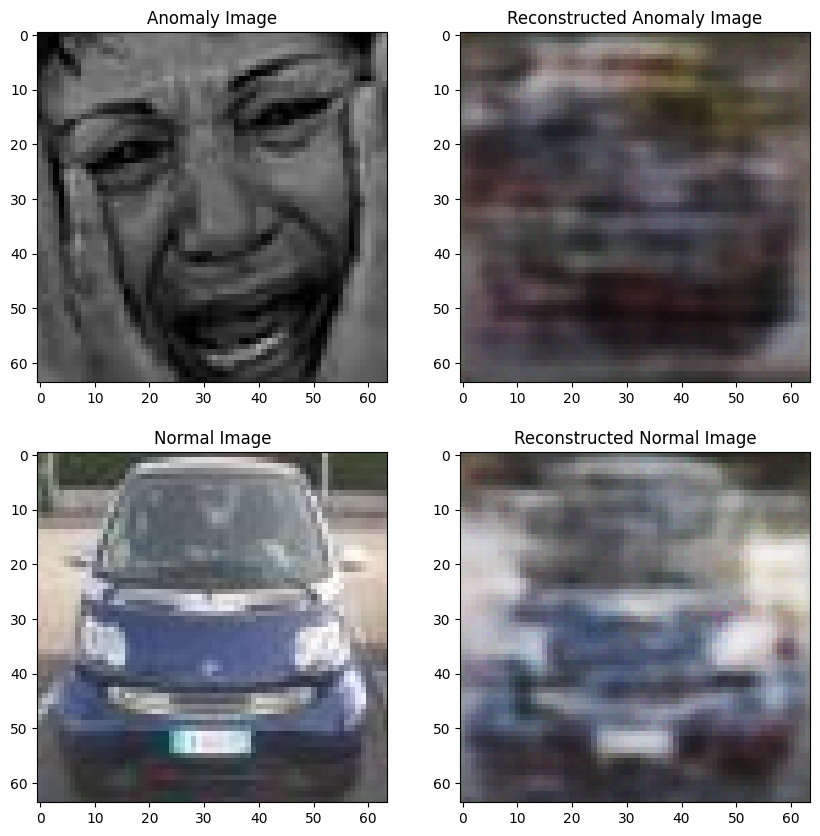

In [32]:
# Use the anomaly dataset and the pre-trained model to generate latent embeddings
anomaly_dataset = ImageDataset(load_unlabelled('/content/data/anomoly'), tfm=T.Compose([
    T.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by adding channels
    T.ToTensor()
]))
anomaly_loader = DataLoader(anomaly_dataset, batch_size=pretrain_config.batch_size, shuffle=False)

# compare losses
anomaly_loss = []
with torch.no_grad():
    for image in anomaly_loader:
        image = image.to(pretrain_config.device)
        recon, _, _ = model(image)
        loss = nn.MSELoss()(recon, image)
        anomaly_loss.append(loss.item())
anomaly_loss = sum(anomaly_loss) / len(anomaly_loss)
print('Anomaly loss:', anomaly_loss)

class1_loss = []
with torch.no_grad():
    for image in class1_loader:
        image = image.to(pretrain_config.device)
        recon, _, _ = model(image)
        loss = nn.MSELoss()(recon, image)
        class1_loss.append(loss.item())
class1_loss = sum(class1_loss) / len(class1_loss)
print('Normal loss :', class1_loss)

# Show
# 1. a pair of reconstructed image and original image for the anomaly class
# 2. a pair of reconstructed image and original image for the normal class
idx1, idx2 = 42, 10
image1, image2 = anomaly_dataset[idx1], class1_dataset[idx2]
model.eval()
with torch.no_grad():
    recon1 = model(image1.unsqueeze(0).to(pretrain_config.device))[0].cpu().numpy()
    recon2 = model(image2.unsqueeze(0).to(pretrain_config.device))[0].cpu().numpy()

# plot the 4 images
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].imshow(image1.numpy().transpose((1, 2, 0)))
axs[0, 0].set_title('Anomaly Image')
axs[0, 1].imshow(recon1.squeeze().transpose((1, 2, 0)))
axs[0, 1].set_title('Reconstructed Anomaly Image')
axs[1, 0].imshow(image2.numpy().transpose((1, 2, 0)))
axs[1, 0].set_title('Normal Image')
axs[1, 1].imshow(recon2.squeeze().transpose((1, 2, 0)))
axs[1, 1].set_title('Reconstructed Normal Image')
plt.show()